In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
df.columns = ['date', 'price']



Переименование колонок для удобства

In [ ]:
df.set_index('date', inplace=True)

Установим индекс по дате для корректной работы моделей временных рядов

In [ ]:
df.info()
print("\nПроверка пропусков:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 2015-01-05 to 2022-08-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   400 non-null    int64
dtypes: int64(1)
memory usage: 6.2 KB

Проверка пропусков:
 price    0
dtype: int64


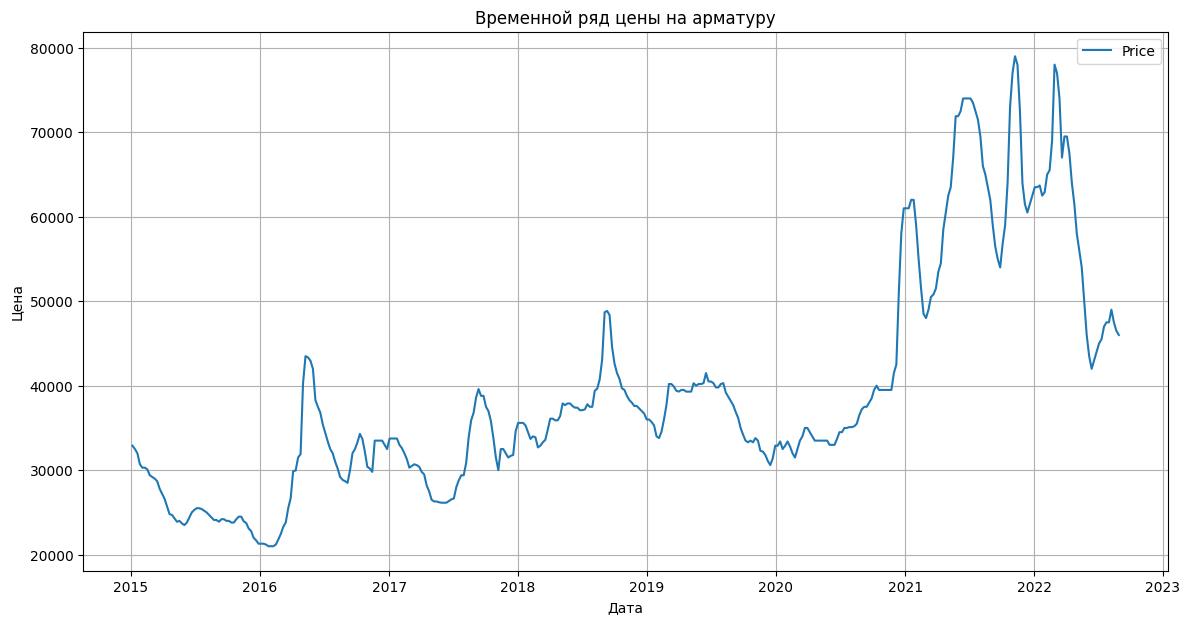

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['price'], label='Price')
plt.title('Временной ряд цены на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

In [ ]:
adf_test = adfuller(df['price'])
print("ADF Test:")
print(f'Test Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Lags Used: {adf_test[2]}')
print(f'Number of Observations Used: {adf_test[3]}')
print(f'Critical Values: {adf_test[4]}')

ADF Test:
Test Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Lags Used: 5
Number of Observations Used: 394
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}



Ряд нестационарный — применяем разности и логарифм



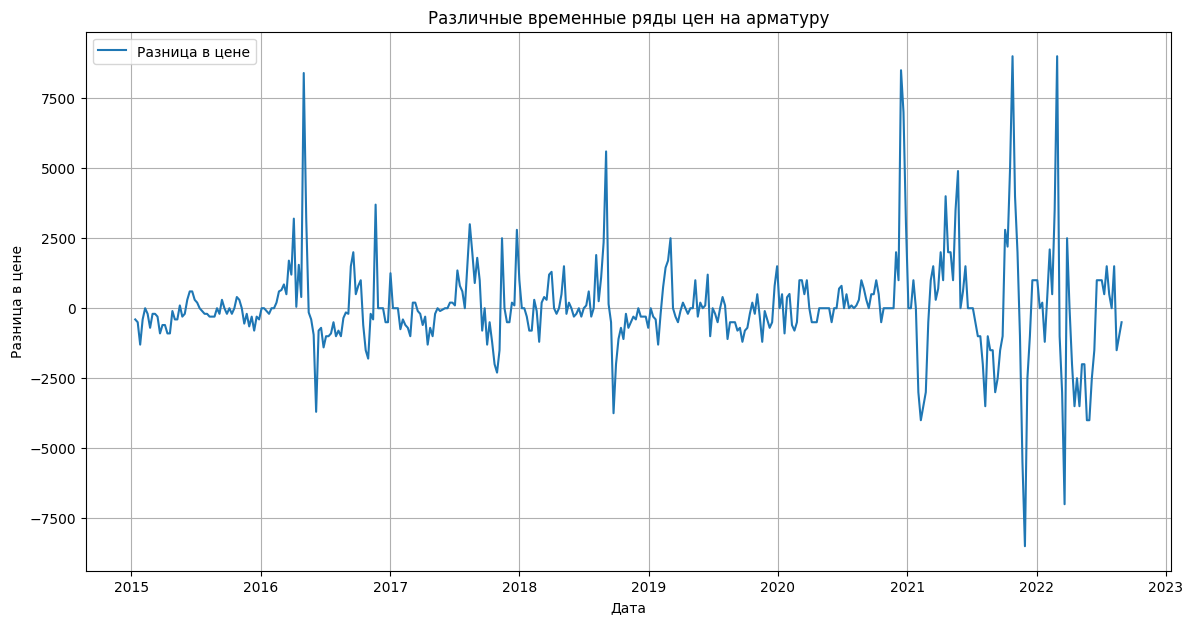

In [ ]:
if adf_test[1] > 0.05:
    print("\nРяд нестационарный — применяем разности и логарифм\n")

    # Разности
    df['price_diff'] = df['price'].diff()

    # Логарифм + разности
    df['price_log'] = np.log(df['price'])
    df['price_log_diff'] = df['price_log'].diff()

    # Визуализация разностей
    plt.figure(figsize=(14, 7))
    plt.plot(df['price_diff'], label='Разница в цене')
    plt.title('Различные временные ряды цен на арматуру')
    plt.xlabel('Дата')
    plt.ylabel('Разница в цене')
    plt.legend()
    plt.grid()
    plt.show()


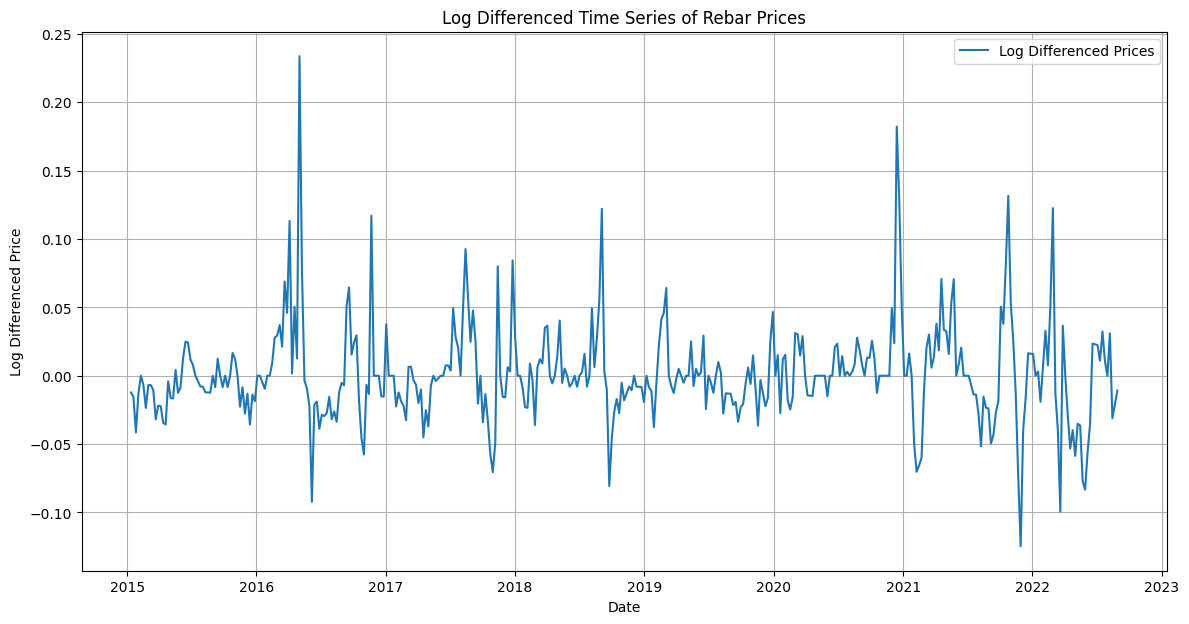

In [26]:
# Визуализация логарифма + разностей
plt.figure(figsize=(14, 7))
plt.plot(df['price_log_diff'], label='Log Differenced Prices')
plt.title('Log Differenced Time Series of Rebar Prices')
plt.xlabel('Date')
plt.ylabel('Log Differenced Price')
plt.legend()
plt.grid()
plt.show()

In [27]:
# ADF-тест на преобразованный ряд
adf_test_diff = adfuller(df['price_diff'].dropna())
print("\nADF Test after Differencing:")
print(f'Test Statistic: {adf_test_diff[0]}')
print(f'p-value: {adf_test_diff[1]}')

adf_test_log_diff = adfuller(df['price_log_diff'].dropna())
print("\nADF Test after Log + Differencing:")
print(f'Test Statistic: {adf_test_log_diff[0]}')
print(f'p-value: {adf_test_log_diff[1]}')


ADF Test after Differencing:
Test Statistic: -7.706061504115209
p-value: 1.300693837380985e-11

ADF Test after Log + Differencing:
Test Statistic: -7.638157651333058
p-value: 1.9275311634352838e-11


# ========== Построение модели ARIMA ==========



Используем параметры ARIMA: p=1, d=1, q=1


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


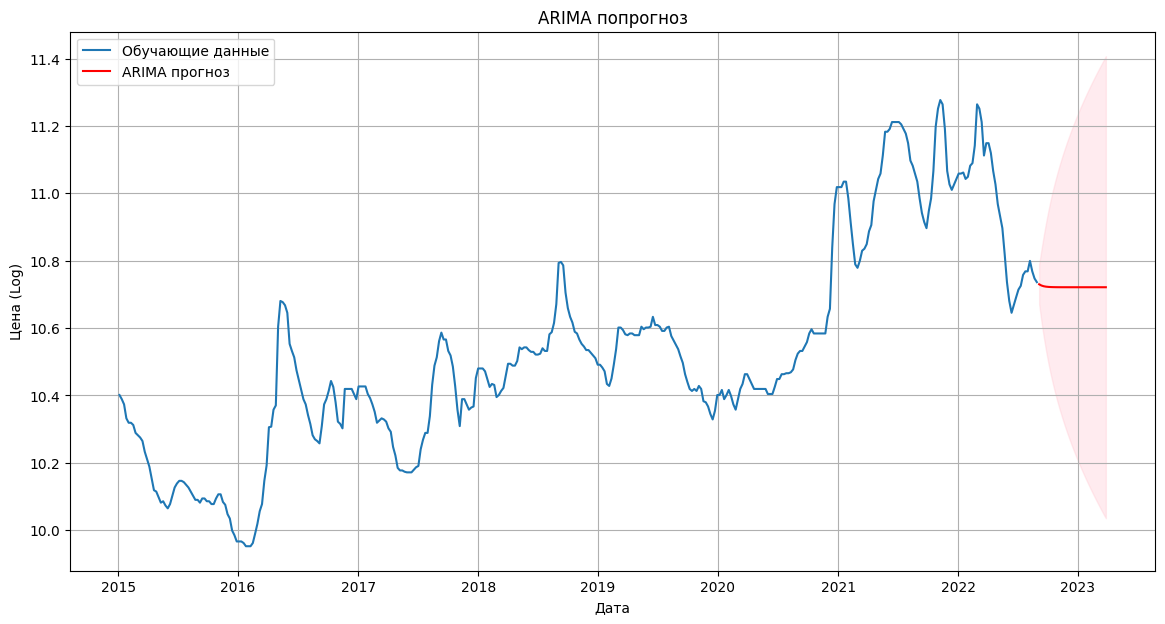

In [30]:
# Подберём параметры вручную на основе ACF и PACF (визуально)
p, d, q = 1, 1, 1  # Пример базовых параметров

print(f"\nИспользуем параметры ARIMA: p={p}, d={d}, q={q}")

arima_model = ARIMA(df['price_log'].dropna(), order=(p, d, q))
arima_result = arima_model.fit()

# Прогноз ARIMA
arima_forecast = arima_result.get_forecast(steps=30)
arima_pred = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

# Визуализация прогноза ARIMA
plt.figure(figsize=(14, 7))
plt.plot(df['price_log'], label='Обучающие данные')
plt.plot(arima_pred, label='ARIMA прогноз', color='red')
plt.fill_between(arima_ci.index, arima_ci.iloc[:, 0], arima_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA пoпрогноз')
plt.xlabel('Дата')
plt.ylabel('Цена (Log)')
plt.legend()
plt.grid()
plt.show()


# ========== Построение модели SARIMA ==========


Используем параметры SARIMA: p=1, d=1, q=1, P=1, D=1, Q=1, m=52


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


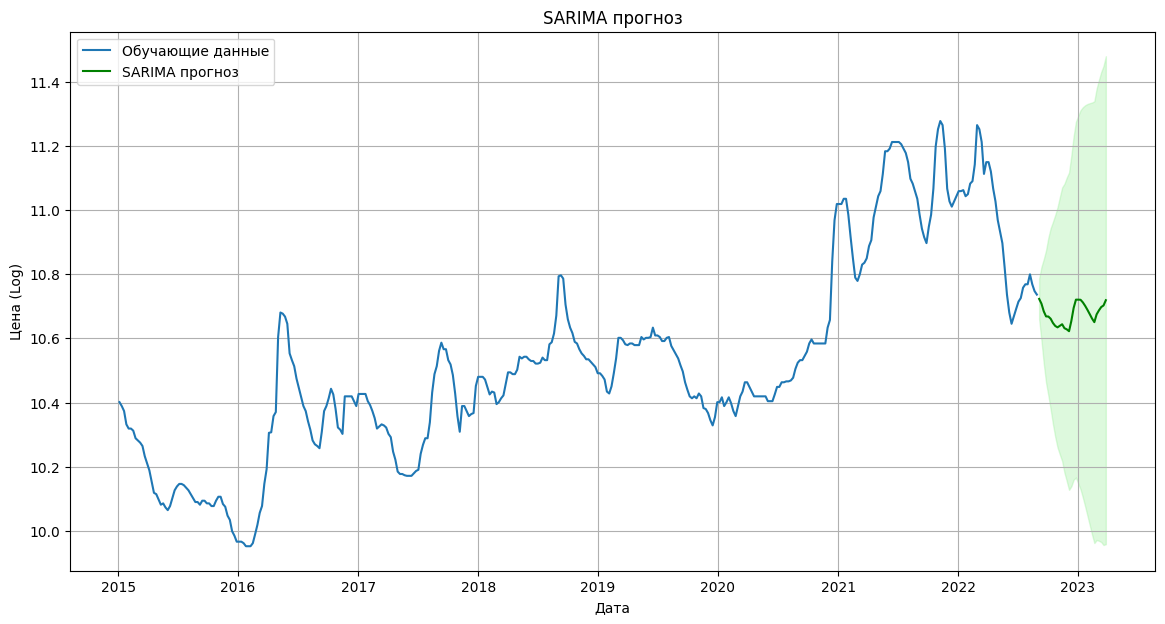

In [31]:
# Параметры SARIMA (подберём вручную)
p, d, q = 1, 1, 1  # Для автокорреляции
P, D, Q, m = 1, 1, 1, 52  # m = 52 — сезонность по годам

print(f"\nИспользуем параметры SARIMA: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, m={m}")

sarima_model = SARIMAX(df['price_log'].dropna(),
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m))
sarima_result = sarima_model.fit()

# Прогноз SARIMA
sarima_forecast = sarima_result.get_forecast(steps=30)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Визуализация прогноза SARIMA
plt.figure(figsize=(14, 7))
plt.plot(df['price_log'], label='Обучающие данные')
plt.plot(sarima_pred, label='SARIMA прогноз', color='green')
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA прогноз')
plt.xlabel('Дата')
plt.ylabel('Цена (Log)')
plt.legend()
plt.grid()
plt.show()
